In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

DATA_ROOT = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 40
LEARNING_RATE = 1e-4
SEED = 44
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [ ]:
# dataset class
class BrainMRIDataset(Dataset):
    #dataset for brain MRI segmentation
    def __init__(self, image_paths, mask_paths, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # load image and mask
        img = Image.open(self.image_paths[idx]).convert('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        # resize
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
        mask = mask.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
        
        # convert to numpy
        img = np.array(img, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)
        
        # normalize image to [0, 1]
        img = img / 255.0
        
        # binarize mask
        mask = (mask > 127.5).astype(np.float32)
        
        # data augmentation
        if self.augment:
            if np.random.random() > 0.5:
                img = np.fliplr(img).copy() 
                mask = np.fliplr(mask).copy() 
            if np.random.random() > 0.5:
                img = np.flipud(img).copy()  
                mask = np.flipud(mask).copy()  
        
        # add channel dimension and convert to torch tensors
        img = torch.from_numpy(img).unsqueeze(0)  # [1, H, W]
        mask = torch.from_numpy(mask).unsqueeze(0)  # [1, H, W]
        
        return img, mask


# data loading
print("Loading image paths...")
all_image_paths = []
all_mask_paths = []

for folder in glob.glob(os.path.join(DATA_ROOT, "*")):
    for f in glob.glob(os.path.join(folder, "*.tif")):
        if f.endswith("_mask.tif"):
            continue
        mask_f = f.replace(".tif", "_mask.tif")
        if os.path.exists(mask_f):
            all_image_paths.append(f)
            all_mask_paths.append(mask_f)

image_paths = np.array(sorted(all_image_paths))
mask_paths = np.array(sorted(all_mask_paths))

print(f"Total pairs: {len(image_paths)}")

# train/validation split
train_img, val_img, train_mask, val_mask = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=SEED, shuffle=True
)

print(f"Train pairs: {len(train_img)}")
print(f"Val pairs: {len(val_img)}")

# create datasets and dataloaders
train_dataset = BrainMRIDataset(train_img, train_mask, augment=True)
val_dataset = BrainMRIDataset(val_img, val_mask, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


PyTorch version: 2.6.0+cu124
CUDA available: True
Loading image paths...
Total pairs: 3929
Train pairs: 3143
Val pairs: 786


In [ ]:
# U-NET
class DoubleConv(nn.Module): #Double Convolution block
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    # U-Net architecture
    
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        # encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        # bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.dropout3 = nn.Dropout2d(0.2)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.dropout2 = nn.Dropout2d(0.2)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.dropout1 = nn.Dropout2d(0.2)
        
        # output
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        # decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dropout3(self.dec3(dec3))
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dropout2(self.dec2(dec2))
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dropout1(self.dec1(dec1))
        
        return torch.sigmoid(self.out(dec1))


In [ ]:
# loss functions and metrics
class DiceLoss(nn.Module):
    
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    # combined BCE and Dice loss
    
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
    
    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice(pred, target)

def dice_coef(pred, target, smooth=1.0):
    # calculate Dice coefficient
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_coef(pred, target, smooth=1.0):
    # calculate IoU coefficient
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)


In [ ]:
# training and validation functions
def train_epoch(model, loader, criterion, optimizer, device):
    # train for one epoch
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # metrics
        with torch.no_grad():
            dice = dice_coef(outputs, masks)
            iou = iou_coef(outputs, masks)
        
        running_loss += loss.item()
        running_dice += dice.item()
        running_iou += iou.item()
        
        pbar.set_postfix({
            'loss': loss.item(),
            'dice': dice.item(),
            'iou': iou.item()
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

def validate_epoch(model, loader, criterion, device):
    # validate for one epoch
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Validation'):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            dice = dice_coef(outputs, masks)
            iou = iou_coef(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice.item()
            running_iou += iou.item()
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou



Initializing model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Model parameters: 7,701,825

Starting training...

Epoch 1/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.50it/s]



Train Loss: 1.3128 | Dice: 0.0270 | IoU: 0.0138
Val Loss: 1.1903 | Dice: 0.0393 | IoU: 0.0203

 Model saved! Best Dice: 0.0393

Epoch 2/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.81it/s]



Train Loss: 1.1322 | Dice: 0.0466 | IoU: 0.0242
Val Loss: 1.0661 | Dice: 0.0673 | IoU: 0.0357

 Model saved! Best Dice: 0.0673

Epoch 3/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.84it/s]



Train Loss: 1.0366 | Dice: 0.0783 | IoU: 0.0418
Val Loss: 0.9975 | Dice: 0.1116 | IoU: 0.0614

 Model saved! Best Dice: 0.1116

Epoch 4/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.82it/s]



Train Loss: 0.9545 | Dice: 0.1271 | IoU: 0.0705
Val Loss: 0.8911 | Dice: 0.1743 | IoU: 0.1005

 Model saved! Best Dice: 0.1743

Epoch 5/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.84it/s]



Train Loss: 0.8574 | Dice: 0.2031 | IoU: 0.1192
Val Loss: 0.7918 | Dice: 0.2743 | IoU: 0.1687

 Model saved! Best Dice: 0.2743

Epoch 6/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.81it/s]



Train Loss: 0.7548 | Dice: 0.2950 | IoU: 0.1834
Val Loss: 0.7097 | Dice: 0.3445 | IoU: 0.2263

 Model saved! Best Dice: 0.3445

Epoch 7/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.81it/s]



Train Loss: 0.6979 | Dice: 0.3491 | IoU: 0.2270
Val Loss: 0.6988 | Dice: 0.3553 | IoU: 0.2293

 Model saved! Best Dice: 0.3553

Epoch 8/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.82it/s]



Train Loss: 0.6487 | Dice: 0.3963 | IoU: 0.2683
Val Loss: 0.5510 | Dice: 0.4891 | IoU: 0.3538

 Model saved! Best Dice: 0.4891

Epoch 9/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.83it/s]



Train Loss: 0.6152 | Dice: 0.4288 | IoU: 0.2974
Val Loss: 0.5695 | Dice: 0.4712 | IoU: 0.3361

Epoch 10/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.85it/s]



Train Loss: 0.5929 | Dice: 0.4510 | IoU: 0.3184
Val Loss: 0.6342 | Dice: 0.4247 | IoU: 0.2921

Epoch 11/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.83it/s]



Train Loss: 0.5626 | Dice: 0.4806 | IoU: 0.3426
Val Loss: 0.5848 | Dice: 0.4599 | IoU: 0.3285

Epoch 12/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.74it/s]



Train Loss: 0.5630 | Dice: 0.4799 | IoU: 0.3456
Val Loss: 0.5258 | Dice: 0.5170 | IoU: 0.3829

 Model saved! Best Dice: 0.5170

Epoch 13/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.79it/s]



Train Loss: 0.5511 | Dice: 0.4929 | IoU: 0.3560
Val Loss: 0.5222 | Dice: 0.5184 | IoU: 0.3867

 Model saved! Best Dice: 0.5184

Epoch 14/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.85it/s]



Train Loss: 0.5527 | Dice: 0.4908 | IoU: 0.3570
Val Loss: 0.5265 | Dice: 0.5147 | IoU: 0.3763

Epoch 15/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.84it/s]



Train Loss: 0.5397 | Dice: 0.5030 | IoU: 0.3695
Val Loss: 0.5191 | Dice: 0.5236 | IoU: 0.3917

 Model saved! Best Dice: 0.5236

Epoch 16/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.85it/s]



Train Loss: 0.5461 | Dice: 0.4971 | IoU: 0.3666
Val Loss: 0.5173 | Dice: 0.5226 | IoU: 0.3908

Epoch 17/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.80it/s]



Train Loss: 0.5264 | Dice: 0.5162 | IoU: 0.3824
Val Loss: 0.5649 | Dice: 0.4785 | IoU: 0.3495

Epoch 18/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.82it/s]



Train Loss: 0.5046 | Dice: 0.5380 | IoU: 0.4001
Val Loss: 0.5085 | Dice: 0.5346 | IoU: 0.3996

 Model saved! Best Dice: 0.5346

Epoch 19/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.81it/s]



Train Loss: 0.5372 | Dice: 0.5062 | IoU: 0.3760
Val Loss: 0.4787 | Dice: 0.5602 | IoU: 0.4236

 Model saved! Best Dice: 0.5602

Epoch 20/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.81it/s]



Train Loss: 0.5240 | Dice: 0.5186 | IoU: 0.3820
Val Loss: 0.5327 | Dice: 0.5105 | IoU: 0.3775

Epoch 21/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.83it/s]



Train Loss: 0.5201 | Dice: 0.5209 | IoU: 0.3903
Val Loss: 0.4870 | Dice: 0.5537 | IoU: 0.4199

Epoch 22/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.81it/s]



Train Loss: 0.4914 | Dice: 0.5497 | IoU: 0.4146
Val Loss: 0.5334 | Dice: 0.5105 | IoU: 0.3790

Epoch 23/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.79it/s]



Train Loss: 0.4970 | Dice: 0.5434 | IoU: 0.4081
Val Loss: 0.4643 | Dice: 0.5719 | IoU: 0.4390

 Model saved! Best Dice: 0.5719

Epoch 24/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.84it/s]



Train Loss: 0.5005 | Dice: 0.5405 | IoU: 0.4057
Val Loss: 0.5025 | Dice: 0.5441 | IoU: 0.4073

Epoch 25/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.84it/s]



Train Loss: 0.5012 | Dice: 0.5394 | IoU: 0.4062
Val Loss: 0.4774 | Dice: 0.5662 | IoU: 0.4336

Epoch 26/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.84it/s]



Train Loss: 0.4736 | Dice: 0.5667 | IoU: 0.4296
Val Loss: 0.4912 | Dice: 0.5483 | IoU: 0.4121

Epoch 27/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.83it/s]



Train Loss: 0.4816 | Dice: 0.5582 | IoU: 0.4235
Val Loss: 0.5024 | Dice: 0.5368 | IoU: 0.3971

Epoch 28/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.79it/s]



Train Loss: 0.4766 | Dice: 0.5637 | IoU: 0.4257
Val Loss: 0.4768 | Dice: 0.5653 | IoU: 0.4271

Epoch 29/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.78it/s]



Train Loss: 0.4847 | Dice: 0.5560 | IoU: 0.4217
Val Loss: 0.4635 | Dice: 0.5746 | IoU: 0.4394

 Model saved! Best Dice: 0.5746

Epoch 30/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.84it/s]



Train Loss: 0.4807 | Dice: 0.5599 | IoU: 0.4266
Val Loss: 0.4650 | Dice: 0.5735 | IoU: 0.4394

Epoch 31/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.82it/s]



Train Loss: 0.4800 | Dice: 0.5594 | IoU: 0.4250
Val Loss: 0.4808 | Dice: 0.5602 | IoU: 0.4263

Epoch 32/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.84it/s]



Train Loss: 0.4787 | Dice: 0.5603 | IoU: 0.4272
Val Loss: 0.4848 | Dice: 0.5558 | IoU: 0.4280

Epoch 33/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.81it/s]



Train Loss: 0.4609 | Dice: 0.5779 | IoU: 0.4442
Val Loss: 0.4679 | Dice: 0.5704 | IoU: 0.4354

Epoch 34/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.82it/s]



Train Loss: 0.4878 | Dice: 0.5526 | IoU: 0.4163
Val Loss: 0.4789 | Dice: 0.5623 | IoU: 0.4244

Epoch 35/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.84it/s]



Train Loss: 0.4674 | Dice: 0.5718 | IoU: 0.4365
Val Loss: 0.4616 | Dice: 0.5750 | IoU: 0.4468

 Model saved! Best Dice: 0.5750

Epoch 36/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.88it/s]



Train Loss: 0.4581 | Dice: 0.5803 | IoU: 0.4457
Val Loss: 0.4789 | Dice: 0.5613 | IoU: 0.4291

Epoch 37/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.83it/s]



Train Loss: 0.4927 | Dice: 0.5469 | IoU: 0.4134
Val Loss: 0.4484 | Dice: 0.5886 | IoU: 0.4555

 Model saved! Best Dice: 0.5886

Epoch 38/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.83it/s]



Train Loss: 0.4428 | Dice: 0.5947 | IoU: 0.4588
Val Loss: 0.4393 | Dice: 0.5955 | IoU: 0.4654

 Model saved! Best Dice: 0.5955

Epoch 39/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.86it/s]



Train Loss: 0.4593 | Dice: 0.5779 | IoU: 0.4460
Val Loss: 0.4456 | Dice: 0.5925 | IoU: 0.4612

Epoch 40/40


Validation: 100%|██████████| 99/99 [00:06<00:00, 14.88it/s]



Train Loss: 0.4626 | Dice: 0.5756 | IoU: 0.4398
Val Loss: 0.4539 | Dice: 0.5817 | IoU: 0.4536


 Training complete!


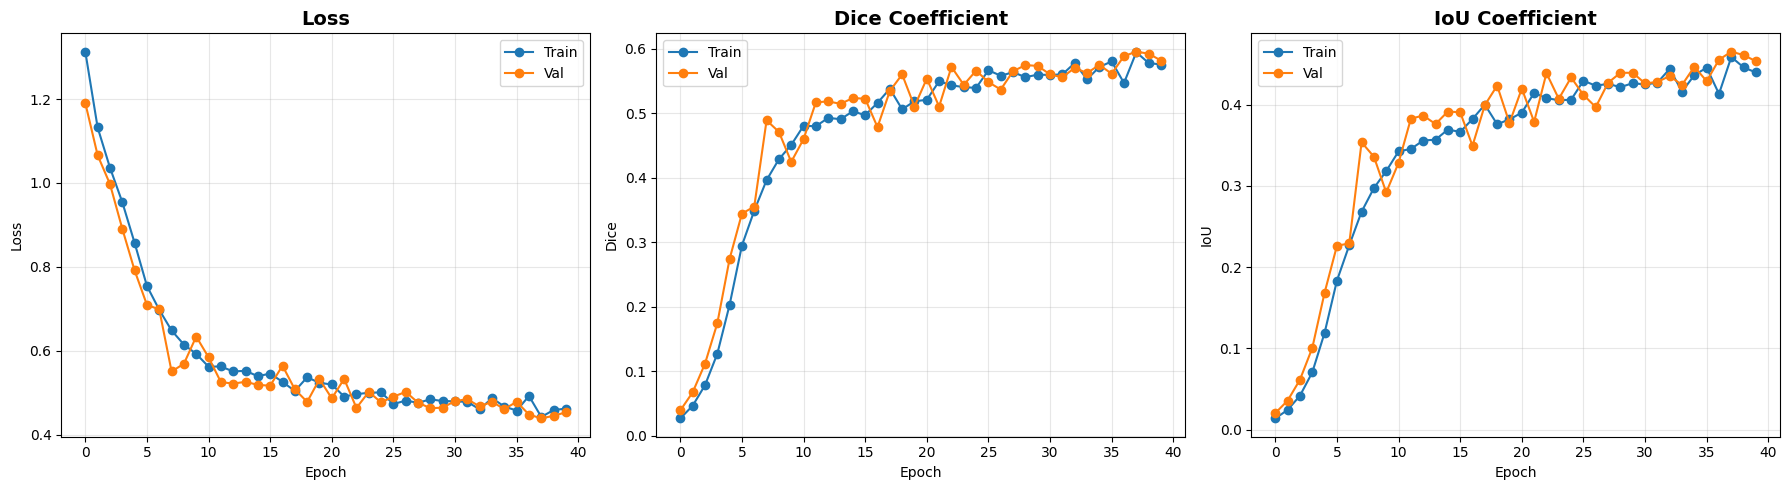

In [ ]:
# initialize model and training
print("\nInitializing model...")
model = UNet(in_channels=1, out_channels=1).to(DEVICE)
criterion = BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")


print("\nStarting training...\n")

history = {
    'train_loss': [], 'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_dice': [], 'val_iou': []
}

best_dice = 0.0
patience_counter = 0
patience = 10

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # train
    train_loss, train_dice, train_iou = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    
    # validate
    val_loss, val_dice, val_iou = validate_epoch(
        model, val_loader, criterion, DEVICE
    )
    
    # update learning rate
    scheduler.step(val_dice)
    
    # save history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}\n")
    
    # save best model
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), 'unet_best.pth')
        print(f" Model saved! Best Dice: {best_dice:.4f}\n")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print("\n Training complete!")

# plotting training history

def plot_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train', marker='o')
    axes[0].plot(history['val_loss'], label='Val', marker='o')
    axes[0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dice
    axes[1].plot(history['train_dice'], label='Train', marker='o')
    axes[1].plot(history['val_dice'], label='Val', marker='o')
    axes[1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # IoU
    axes[2].plot(history['train_iou'], label='Train', marker='o')
    axes[2].plot(history['val_iou'], label='Val', marker='o')
    axes[2].set_title('IoU Coefficient', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_history(history)


Generating predictions...
8


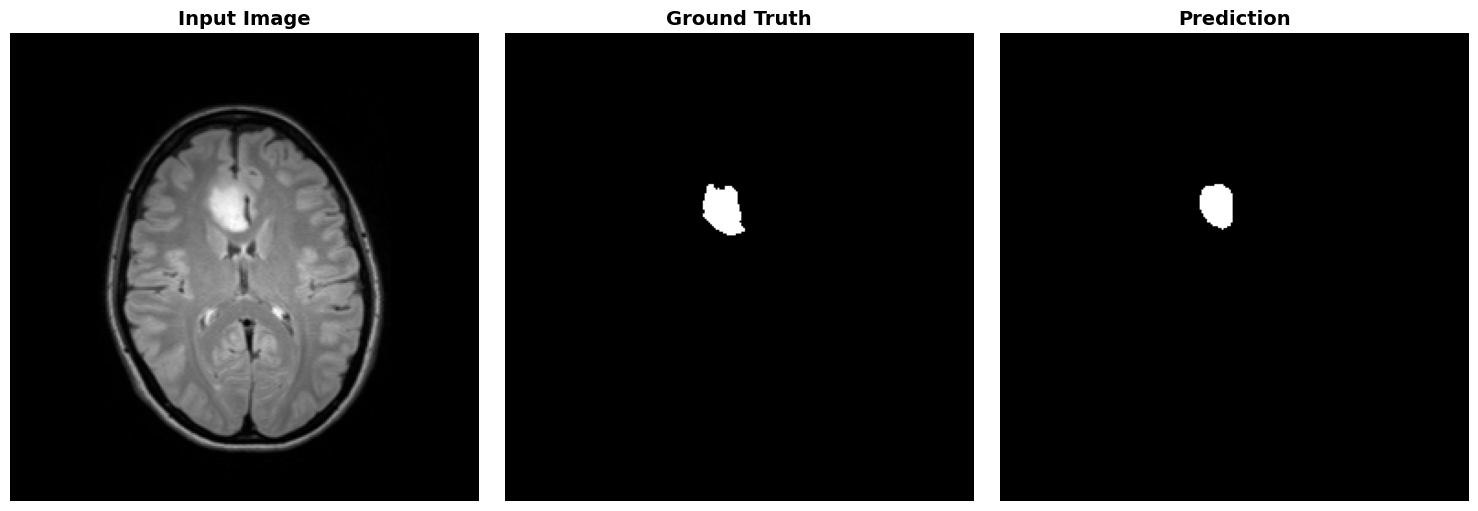

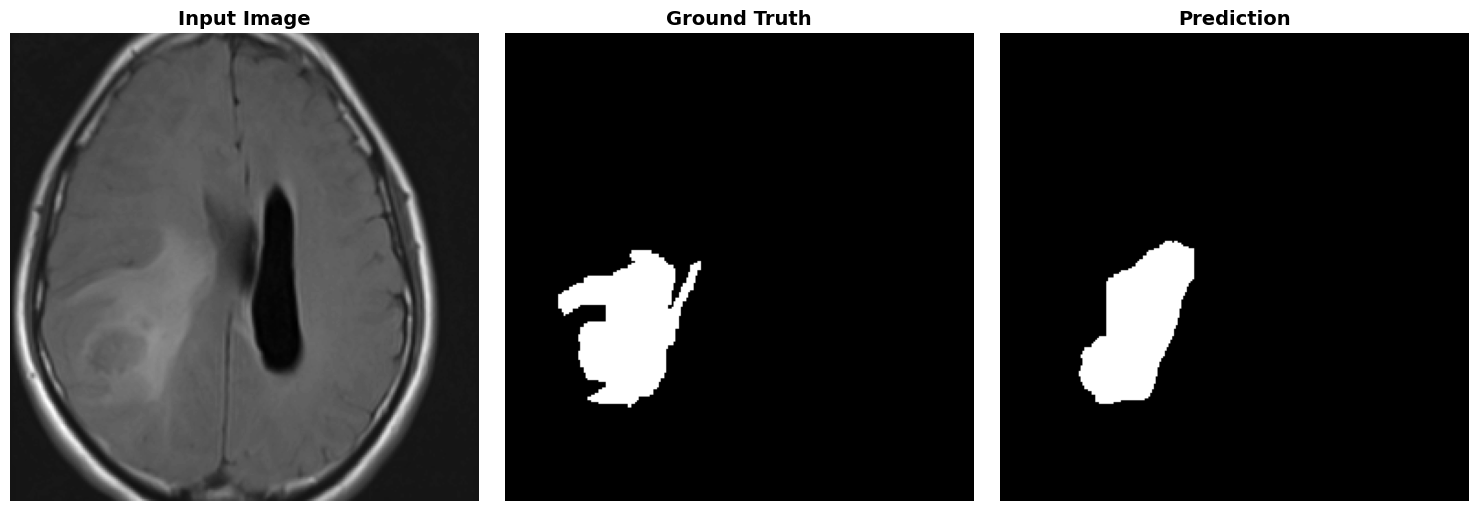

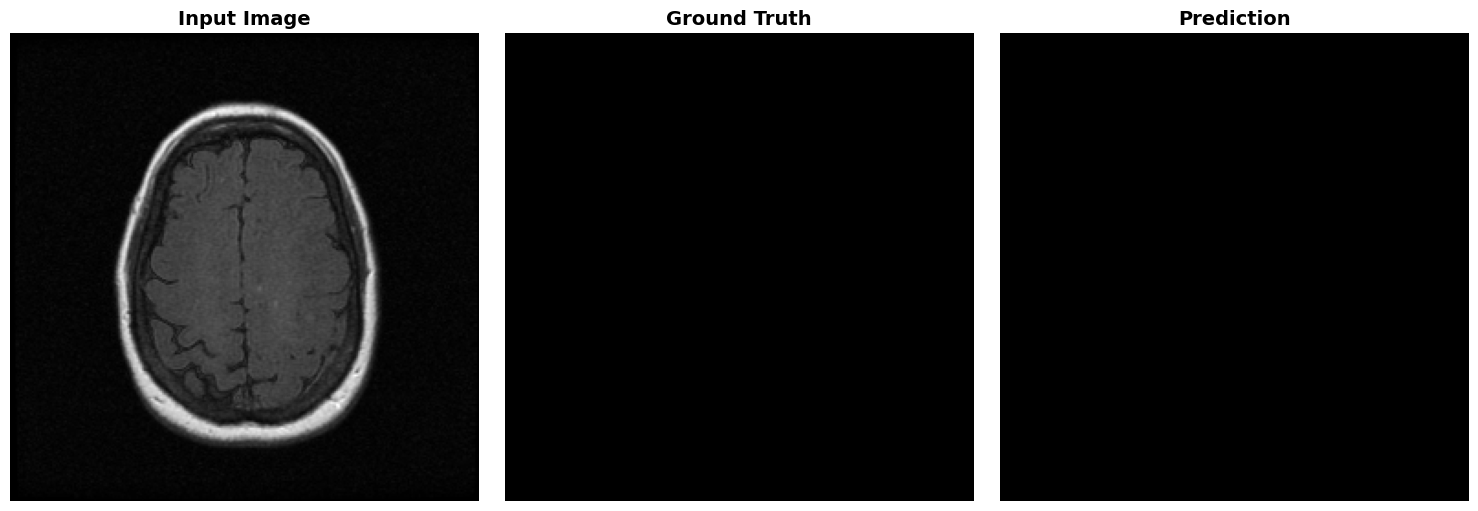

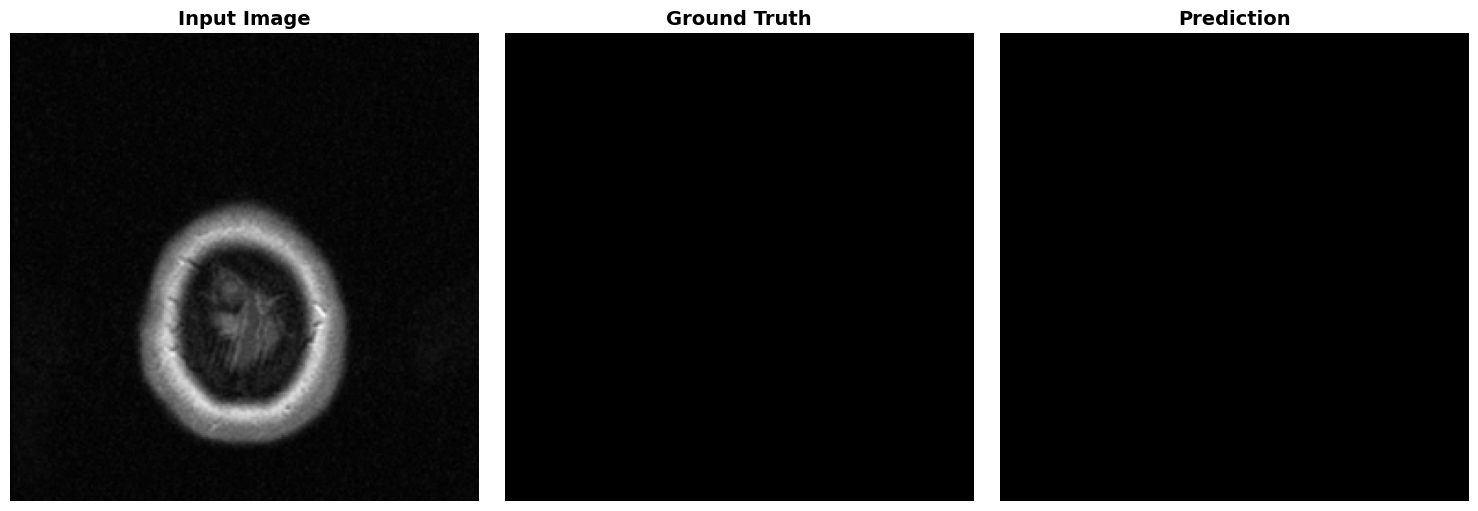

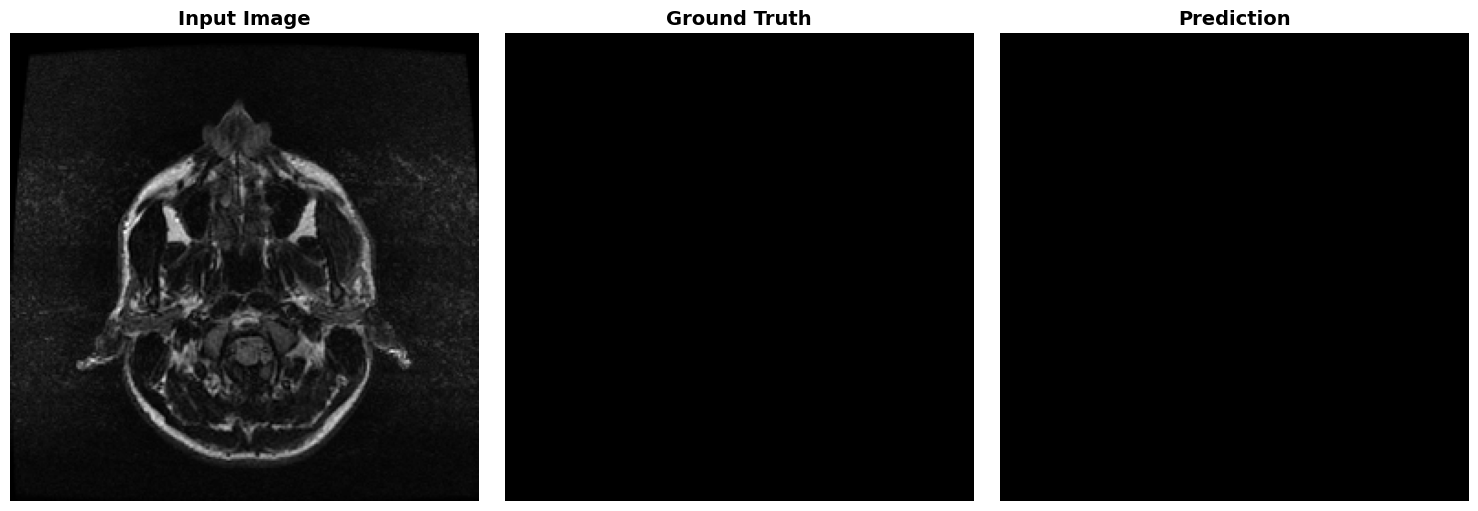

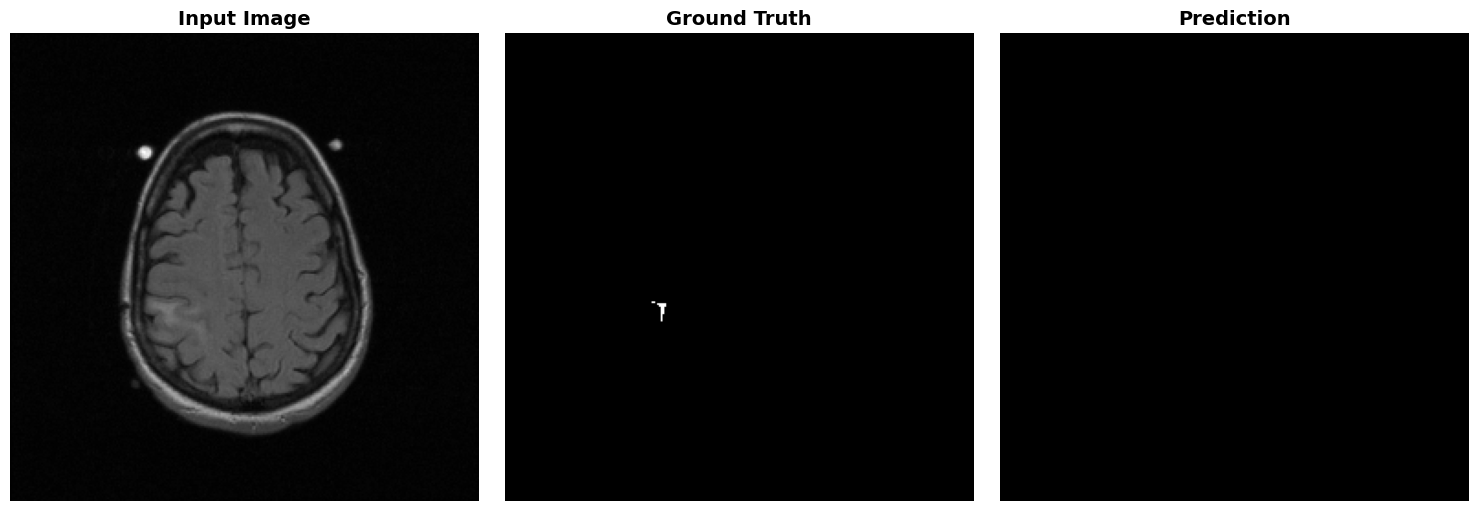

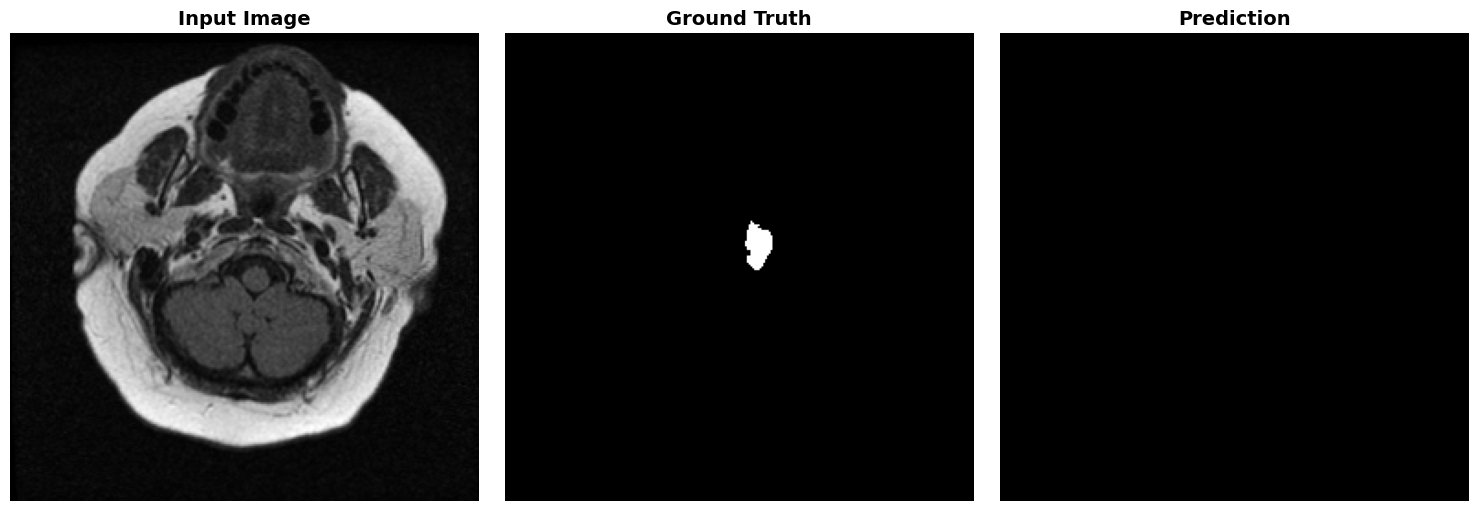

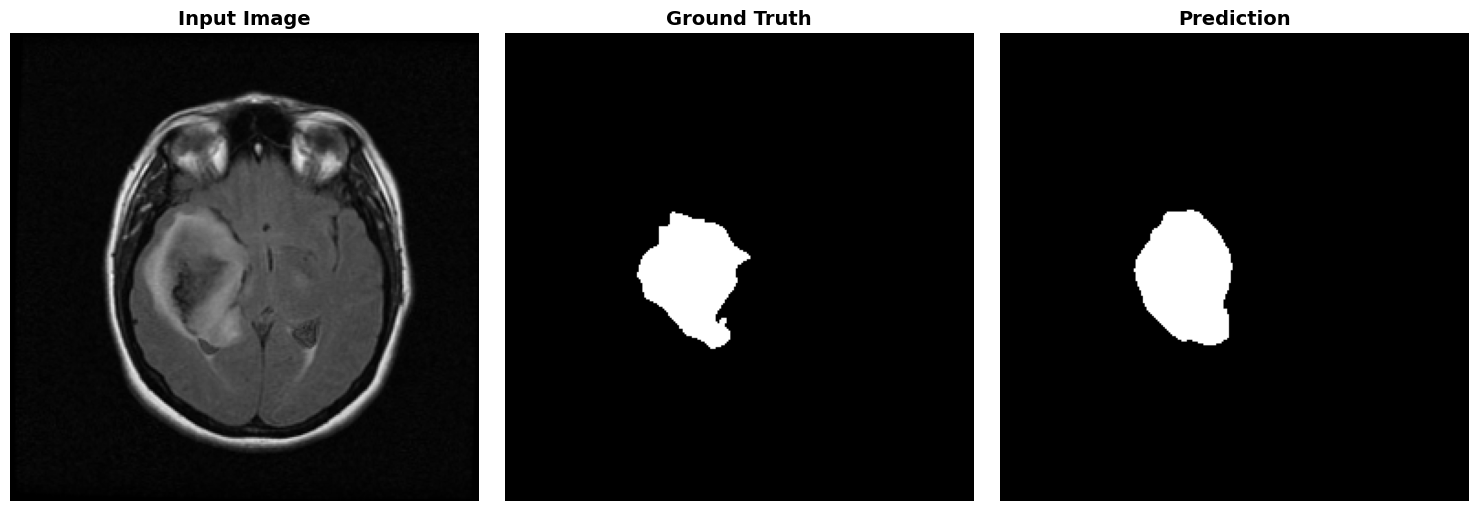


 All done.


In [ ]:
# visualize predictions
print("\nGenerating predictions...")
model.eval()

# get a batch from validation set
images, masks = next(iter(val_loader))
images = images.to(DEVICE)

with torch.no_grad():
    predictions = model(images)

# move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
predictions = predictions.cpu()

# binarize predictions
predictions_bin = (predictions > 0.5).float()

# visualize
def display_sample(img, true_mask, pred_mask):
    #display input image, ground truth, and prediction
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img.squeeze(), cmap='gray')
    axes[0].set_title('Input Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(true_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(pred_mask.squeeze(), cmap='gray')
    axes[2].set_title('Prediction', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show first 8 samples
print(images.shape[0])
num_to_show = min(8, images.shape[0])
for i in range(num_to_show):
    display_sample(images[i], masks[i], predictions_bin[i])

print("\n All done.")